In [62]:
import sys
import pdb
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance

In [89]:
importlib.reload(putil)

def make_plot(latband, pres, ulev, ilev, budgetdates, sigvar='pval', ufreq='10daily', tropics_label=False):

    # ----- whether or not to skip the non-source-tagged ensemble members
    skipnst=True
    mass=10
    
    # ----- set limits
    plim    = [400, 0.5]
    #timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]
    #timelim = [datetime(1991,6,1), datetime(1993,7,1)]
    timelim = [date(1991,6,2), date(1993,7,1)]
    
    # ----- get U data
    ub = putil.get_variable('U', skip_nosrctag=skipnst, freq=ufreq, mass=mass, 
                            tmin=timelim[0], tmax=timelim[1], pmin=pres-2, pmax=pres+2,
                            average_time=False, average_lat=False, average_pres=False)
    # ----- get latband U data
    u  = putil.get_variable('U', skip_nosrctag=skipnst, freq=ufreq, mass=mass, latmin=latband[0], latmax=latband[1], 
                            tmin=timelim[0], tmax=timelim[1], average_lat=True, average_pres=False, average_time=False)
    
    # ----- get dims
    time, plev = [u['cfmean'].time, u['cfmean'].plev]
    time       = [datetime(t.year,t.month,t.day) for t in time.values]
    lat        = ub['cfmean'].lat

    # ----- plotting settings
    pcrit       = 0.05     # p-value significance threshold
    icmap       = 'RdBu_r' # impact colormap
    isiglw      = 2.5      # significance contour linewidth
    isigcolor   = 'w'      # significance contour color
    ihatch      = '/////'  # insignificance hatching type
    ihatchlw    = 1        # insignificance hatching linewidth
    ihatchcolor = 'w'      # insignificance hatching color
    ucolor      = 'k'      # contour color for U
    ulw         = 1.2      # line width for U contours
    ulwz        = ulw*1.7  # line width for U zero-line
    ualph       = 0.75     # alpha for U contours
    eqcolor     = 'm'      # equator line color 
    eqls        = '-'      # equator linestyle
    eqlw        = 1.5      # equator line width
    eqalph      = 0.5      # equator alpha
    ercolor     = 'yellow' # eruption line color 
    erls        = '-'      # eruption linestyle
    erlw        = 2        # eruption line width
    cbheight = 0.765
    cbpos = [0.915, (1-cbheight)/2-0.005, 
             0.02, cbheight] # colorbar position
    mpl.rcParams['hatch.linewidth'] = ihatchlw
    mpl.rcParams['hatch.color']     = ihatchcolor

    # ---------- plot
    fig_width = 10
    fig = plt.figure(figsize=(fig_width, fig_width/3))
    gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 2.5])

    # ========== first plot the pressure level data from lat_time_impact on this lat band
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # ----- level settings
    inorm  = putil.get_cmap_norm(ilev, 'twoslope') # colormap normalization
    pargs  = {'plev':pres, 'method':'nearest'}
    pp = lambda d: d.sel(**pargs).transpose('lat','time')

    # --- ensemble data
    ax1.contour(time, lat, pp(ub['cfmean']), colors=ucolor, linewidths=ulw, levels=ulev, alpha=ualph, zorder=10)
    ax1.contour(time, lat, pp(ub['cfmean']), colors=ucolor, linewidths=ulwz, levels=[0], alpha=ualph, zorder=10)
    # --- impact data
    ax1.contourf(time, lat, pp(ub['impact']), cmap=icmap, levels=ilev, norm=inorm, extend='both')
    # --- pval
    ax1.contourf(time, lat, pp(ub['pval']), levels=[pcrit, pp(ub['pval']).max()], hatches=[ihatch], alpha=0)
    ax1.contour(time, lat, pp(ub['pval']), colors=isigcolor, levels=[pcrit], linewidths=isiglw)

    # --- eruption
    ax1.axvline(x=datetime(1991, 6, 15), color=ercolor, ls=erls, lw=erlw, zorder=11)

    # ----- format
    putil.season_timeticks(ax1, time, 'season', include_year=True)
    putil.format_lataxis(ax1, which='y')
    ax1.set_yticks(np.arange(latband[0], latband[1]+1, 10))
    ax1.set_ylim([latband[0]-5, latband[1]+5])
    ax1.set_xlim(timelim)
    ax1.tick_params(top=True, bottom=True, left=True, right=True, 
                    labeltop=False, labelbottom=False, labelleft=True, labelright=False, 
                    which='both')

    # ----- make legend
    if(not tropics_label):
        label = 'counterfactual $\\overline{{u}}$ every {} m s$^{{-1}}$'.format(np.diff(ulev)[0])
    else:
        levlabels = ['$\\pm${}'.format(ll) for ll in np.array(ulev)[np.array(ulev)>0]]
        levlabels = ', '.join(levlabels)
        label = 'counterfactual $\\overline{{u}}$ at 0, {} m s$^{{-1}}$'.format(levlabels)
    dummy = ax1.plot([0,0],[0,0], color=ucolor, lw=ulw, alpha=ualph,label=label)
    leg = ax1.legend(bbox_to_anchor=(1.011, 1.76), frameon=True, fancybox=False, edgecolor='k', ncol=1, columnspacing=0.5, handlelength=1.5)
    leg.get_frame().set_linewidth(0.66)

    # ----- make pressure label box
    ax1.text(0, 1.36, '{} hPa'.format(pres), transform=ax1.transAxes, verticalalignment='top', fontsize=15, zorder=1000,
        bbox=dict(facecolor='none', edgecolor='none'))

    # ========== now plot the band average p-time impact
    pp = lambda d: d.transpose('plev','time')

    # --- ensemble data
    ax2.contour(time, plev, pp(u['cfmean']), colors=ucolor, linewidths=ulw, levels=ulev, alpha=ualph, zorder=10)
    ax2.contour(time, plev, pp(u['cfmean']), colors=ucolor, linewidths=ulwz, levels=[0], alpha=ualph, zorder=10)
    # --- impact data
    cfui = ax2.contourf(time, plev, pp(u['impact']), cmap=icmap, levels=ilev, norm=inorm, extend='both')
    # --- pval
    ax2.contourf(time, plev, pp(u['pval']), levels=[pcrit, u['pval'].max()], hatches=[ihatch], alpha=0)
    ax2.contour(time, plev, pp(u['pval']), colors=isigcolor, levels=[pcrit], linewidths=isiglw)

    # --- eruption
    ax2.axvline(x=datetime(1991,6,15), color=ercolor, ls=erls, lw=erlw, zorder=11)
    # --- pressure line
    ##ax2.axhline(y=pres, color='yellow', ls='-', lw=2, zorder=300)

    # ----- format
    putil.season_timeticks(ax2, time, 'season', include_year=True)
    ax2.set_ylabel('pressure [hPa]')
    ax2.set_ylim(plim)
    putil.format_paxis(ax2)
    ax2.set_xlim(timelim)
    ax2.tick_params(top=True, bottom=True, left=True, right=True, 
                    labeltop=False, labelbottom=True, labelleft=True, labelright=False, 
                    which='both')

    # ----- make colorbar
    cb = fig.colorbar(cfui, cax=fig.add_axes(cbpos), orientation='vertical', location='right', format='%d', extendrect=True)
    cb.set_label('$\\overline{{u}}$ impact [m s$^{{-1}}$]')
    cb.set_ticks(ilev)

    # ----- format subplots
    fig.subplots_adjust(hspace=0.15)
    
    # ---- subplot labels
    letter = ['(a)','(b)']
    for i, axi in enumerate([ax1, ax2]):
        axi.annotate(letter[i], xy=(-0.04, 1.04), xycoords="axes fraction", fontsize=14, weight = 'bold')
    
    # ==================== make inset plots for budget curves ====================
    
    # ----- get integrated tendencies
    fargs = {'skip_nosrctag':skipnst, 'freq':'daily', 'mass':mass, 
             'latmin':latband[0], 'latmax':latband[1], 'average_lat':True,
             'tmin':timelim[0], 'tmax':timelim[1], 'average_time':False,
             'pmin':pres-5, 'pmax':pres+5, 'average_pres':False}
    pargs = {'plev':pres, 'method':'nearest'}
    
    # ----- get U
    uu = putil.get_variable('U', skip_nosrctag=skipnst, freq=ufreq, mass=mass, latmin=latband[0], latmax=latband[1],
                           tmin=timelim[0], tmax=timelim[1], average_lat=True, average_pres=False, average_time=False)
    uu = uu['impact'].sel(**pargs) # U at the pressure level
    
    # ----- plotting settings
    pad               = 0.075  # padding space for inset axes
    ils, ilw, icolor  = ':', 1.33, 'k'    # line style, width, and color for zoom-in indicator rays 
    brlw, brcolor, bralph = 8,'greenyellow', 0.66 # line width, color, alpha for averaging region idicator on main figure
    blw, bslw         = 1.5, 6     # line with for integrated tendencies, significant integrated tendencies
    balpha            = 0.25     # alpha for significant integrated tendency highlight
    zls, zlw, zcolor  = ':', 1.2, 'grey' # zero-line linestyle, width, and color
    utls, utcolor     = '-','k'  # linestyle and color for integrated utend
    utepls, ueptcolor = '-','indianred'  # linestyle and color for integrated utendepfd
    utrvls, utrvcolor = '-','dodgerblue'  # linestyle and color for integrated utendresvel
    utvls, utvcolor   = '--','dodgerblue' # linestyle and color for integrated utendvtem
    utwls, utwcolor   = '-.','dodgerblue'  # linestyle and color for integrated utendwtem
    utdls, utdcolor   = '-','gold'  # linestyle and color for integrated utenddiff

    # ----- loop over all passed budgeting time windows
    nb = len(budgetdates)
    for i in range(nb):
        
        # get time coordinate and limits for zoom-in region
        bdates = budgetdates[i]
        blim   = putil.to_datetime(bdates)
        targs = {'tmin':bdates[0], 'tmax':bdates[1]}
        
        # pad and shift the axes so that they are evenly distributed across
        # the bottom of the figure. Took me forever to derive this.
        shrink = (nb-1)*pad/nb
        shift  = (np.arange(1, nb+1, 1)-1)*pad/nb
        
        # create axes for zoom-in region
        bax = ax2.inset_axes([i/nb + shift[i], -1.25, 1/nb - shrink, 1])
        # create zoom-in indicators from the main figure to the insets
        bax.set_ylim([pres-1e-6,pres+1e-6])
        bax.set_xlim(blim)
        zoomrect, zoomlines = ax2.indicate_inset_zoom(bax)
        for line in zoomlines:
            line.set_color(icolor)
            line.set_linewidth(ilw)
            line.set_linestyle(ils)
        ax2.plot(blim, [pres, pres], '-', color=brcolor, lw=brlw, solid_capstyle='round', alpha=bralph, zorder=300)
            
        # ----- get integrated tendencies initalized at this time
        ut   = putil.get_integrated_tendency('UTEND', tinit=bdates[0], **fargs)
        utep = putil.get_integrated_tendency('utendepfd', tinit=bdates[0], **fargs)
        utrv = putil.get_integrated_tendency('utendresvel', tinit=bdates[0], **fargs)
        utv  = putil.get_integrated_tendency('utendvtem', tinit=bdates[0], **fargs)
        utw  = putil.get_integrated_tendency('utendwtem', tinit=bdates[0], **fargs)
        utd  = putil.get_integrated_tendency('utenddiff', tinit=bdates[0], **fargs)
        # ----- slice
        ut   = putil.sel(putil.do_slicing(ut, **targs), **pargs)
        utep = putil.sel(putil.do_slicing(utep, **targs), **pargs)
        utrv = putil.sel(putil.do_slicing(utrv, **targs), **pargs)
        utv  = putil.sel(putil.do_slicing(utv, **targs), **pargs)
        utw  = putil.sel(putil.do_slicing(utw, **targs), **pargs)
        utd  = putil.sel(putil.do_slicing(utd, **targs), **pargs)
        # ----- get significance
        ut_sig = sig(ut['impact'], ut[sigvar], sigtype=sigvar)
        utep_sig = sig(utep['impact'], utep[sigvar], sigtype=sigvar)
        utrv_sig = sig(utrv['impact'], utrv[sigvar], sigtype=sigvar)
        utv_sig = sig(utv['impact'], utv[sigvar], sigtype=sigvar)
        utw_sig = sig(utw['impact'], utw[sigvar], sigtype=sigvar)
        utd_sig = sig(utd['impact'], utd[sigvar], sigtype=sigvar)

        # get time coordinate for plotting
        btime = putil.to_datetime(ut['impact'].time)
        
        # plot
        #bax.plot(btime, putil.do_slicing(uu, **targs), lw=blw*4, ls='--', color=utcolor) # plot U as sanity check on UTEND
        bax.plot(btime, ut['impact'], lw=blw, ls=utls, color=utcolor, label='$\\partial\\overline{u}/\\partial{t}$')
        bax.plot(btime, utep['impact'], lw=blw, ls=utepls, color=ueptcolor, label='$\\nabla\\cdot\\mathbf{F}$')
        bax.plot(btime, utrv['impact'], lw=blw, ls=utrvls, color=utrvcolor, label='($v^*$, $w^*$)')
        bax.plot(btime, utv['impact'], lw=blw-0.3, ls=utvls, color=utvcolor, label='$v^*$')
        bax.plot(btime, utw['impact'], lw=blw-0.3, ls=utwls, color=utwcolor, label='$w^*$')
        bax.plot(btime, utd['impact'], lw=blw, ls=utdls, color=utdcolor, label='$\\overline{X}$')
        
        # scale y-axis
        ydata = np.concatenate([line.get_ydata() for line in bax.get_lines()])
        ymin, ymax = np.min(ydata), np.max(ydata)
        bax.set_ylim([ymin-np.abs(ymin*0.1), ymax+np.abs(ymax*0.1)])
        
        # plot significance
        bax.plot(btime, ut_sig, lw=bslw, alpha=balpha, ls=utls, color=utcolor)
        bax.plot(btime, utep_sig, lw=bslw, alpha=balpha, ls=utepls, color=ueptcolor)
        bax.plot(btime, utrv_sig, lw=bslw, alpha=balpha, ls=utrvls, color=utrvcolor)
        bax.plot(btime, utv_sig, lw=bslw, alpha=balpha, ls=utrvls, color=utvcolor)
        bax.plot(btime, utw_sig, lw=bslw, alpha=balpha, ls=utrvls, color=utwcolor)
        bax.plot(btime, utd_sig, lw=bslw, alpha=balpha, ls=utdls, color=utdcolor)
        
        # zero line
        #bax.axhline(y=0, lw=zlw, ls=zls, color=zcolor, zorder=0)
        # --- color negative region
        ylim = bax.get_ylim()
        bax.fill_between(btime, y1=np.zeros(len(btime))*0, y2=np.zeros(len(btime))+ylim[0], color='k', alpha=0.07)
        bax.set_ylim(ylim)
        
        # legend
        if(i==0):
            dummy = fig.add_axes(ax2.get_position(), frameon=False)
            dummy.tick_params(left=False, right=False, top=False, bottom=False,
                              labelleft=False, labelbottom=False)
            for line in bax.get_lines():
                dummy.plot([0],[0], lw=line.get_lw(), ls=line.get_ls(), color=line.get_color(), label=line.get_label())
            leg = dummy.legend(bbox_to_anchor=(0.5, -1.5), frameon=False, fancybox=False, edgecolor='k', ncol=6, columnspacing=1, handlelength=1.5, loc='center')
            leg.get_frame().set_linewidth(0.66)
        
        # formatting
        bax.set_xlim([btime[0], btime[-1]])
        putil.season_timeticks(bax, btime, 'month')
        bax.tick_params(top=True, bottom=True, left=True, right=True, 
                        labeltop=False, labelbottom=True, labelleft=True, labelright=False, 
                        which='both')
        if(i == 0):
            bax.set_ylabel('integrated \n$\\overline{u}$ impact [m s$^{{-1}}$]')
            
        # ---- subplot labels
        letter = ['(c)','(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
        bax.annotate(letter[i], xy=(0.025, 0.07), xycoords="axes fraction", fontsize=14, weight = 'bold')

plotting tropics...
plotting NH midlats...


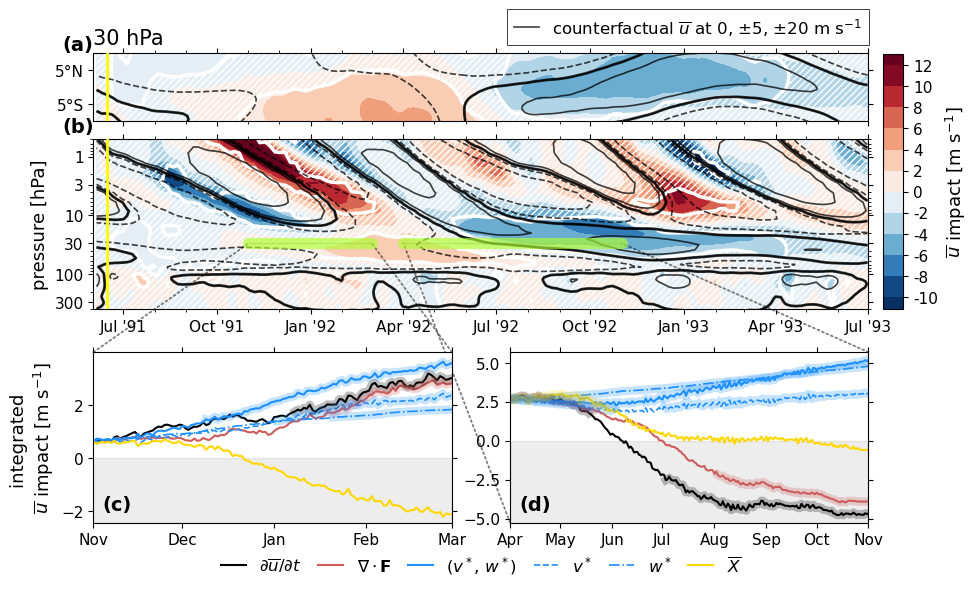

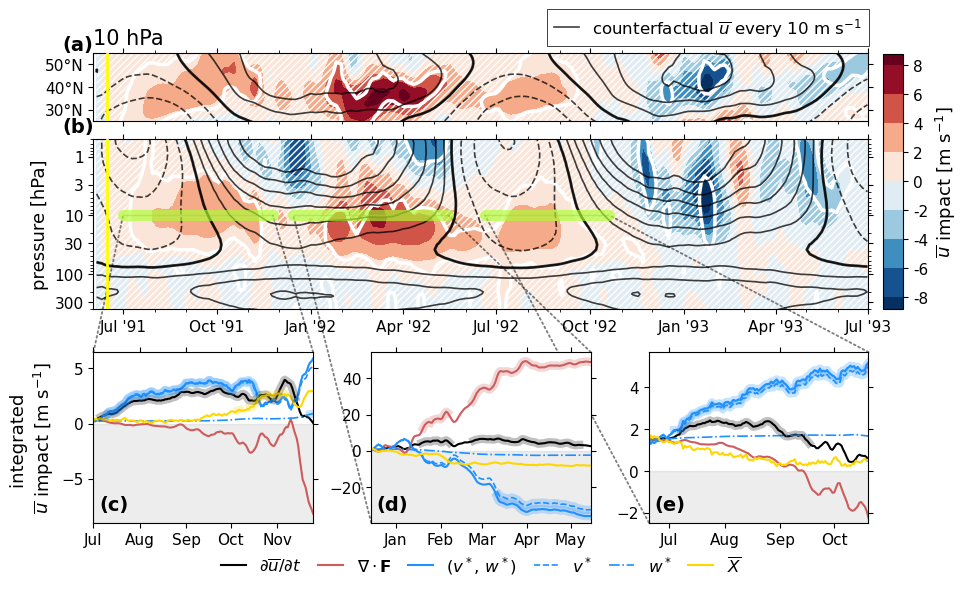

In [90]:
importlib.reload(putil)
importlib.reload(ces)

#sigvar = 'coherence'
sigvar = 'pval'

print('plotting tropics...')
# ========== TROPICS
latband = [-5, 5]
plev = 30
ilev = np.arange(-10, 12+1, 2)
ulev = np.hstack([np.arange(-45, -15+1, 15), [-5, 0, 5], np.arange(15, 45+1, 15)])
#ulev = np.arange(-45, 46, 5)
ulev = [-30, -15, -5, 0, 5, 15, 30]
ulev = [-20, -5, 0, 5, 20]
budgetlim = [[date(1991, 11, 1), date(1992, 3, 1)], 
             [date(1992, 4, 1), date(1992, 11, 1)]]
make_plot(latband, plev, ulev, ilev, budgetlim, sigvar, tropics_label=True)
plt.savefig('figs/tropics_timepBudget_{}panel.pdf'.format(len(budgetlim)), dpi=200, bbox_inches='tight')

# ========== NORTHERN MIDLATS
print('plotting NH midlats...')
latband = [30, 50]
plev = 10
ilev = np.arange(-8, 8+1, 2)
ulev = np.arange(-30, 60+1, 10)
#budgetlim = [[date(1991, 7, 1), date(1991, 9, 15)], 
#             [date(1991, 10, 15), date(1992, 3, 1)],
#             [date(1992, 6, 1), date(1992, 11, 1)]]
budgetlim = [[date(1991, 7, 1), date(1991, 11, 25)], 
             [date(1991, 12, 15), date(1992, 5, 15)],
             [date(1992, 6, 20), date(1992, 10, 20)]]
make_plot(latband, plev, ulev, ilev, budgetlim, sigvar)
plt.savefig('figs/NH_timepBudget_{}panel.pdf'.format(len(budgetlim)), dpi=200, bbox_inches='tight')

if(0):
    print('plotting NH polar...')
    # ========== NORTHERN POLAR
    latband = [45, 65]
    plev = 1
    ilev = np.arange(-8, 8+1, 2)
    ulev = np.arange(-30, 60+1, 10)
    budgetlim = [[date(1991, 9, 1), date(1992, 7, 1)], 
                 [date(1992, 11, 1), date(1993, 4, 1)]]
    make_plot(latband, plev, ulev, ilev, budgetlim, sigvar)
    
plt.show()